# Overview
- Calculate SFZ districts for all of big island
- Review zoning proposals Ron shared
- Adapt "what it enables" slide
- Add slide connecting EiZPG to Ron proposals

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

albers_hi = '+proj=aea +lat_0=13 +lon_0=-157 +lat_1=8 +lat_2=18 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'


In [34]:
county = gpd.read_file('./data/zoning_maps/HawaiiCountyHawaiiCountyHI-ZoningDistricts.geojson')



In [35]:
county = county[['Jurisdiction','Abbreviated District Name', 'Full District Name', 'Type of Zoning District',
          '1-Family Treatment', '1-Family Max. Height', '1-Family Floor to Area Ratio', '4+-Family Treatment',
          '1-Family Min. Lot', '1-Family Min. # Parking Spaces', 'Accessory Dwelling Unit (ADU) Treatment', 'geometry']]



In [36]:
# project to albers hi
county['geometry'] = county['geometry'].to_crs(albers_hi)

# calculate zone areas in house districts
zoned_area = sum(county.geometry.area)
county['zone_area'] = county.geometry.area

# calculate % area for each zone
county['zone_pct'] = county['zone_area'] / zoned_area

# one-hot flag for single-family
# county['single_family'] = county['Abbreviated District Name'].str.startswith("R-")
county['single_family'] = county['Abbreviated District Name'].str.match(r"^R-|RS-|RD-|RM-|RA-")

# HI County screwing things up. 
county['num_suffix'] = county['Abbreviated District Name'].str.findall(r"""(?<=-)\d\.\d|(?<=-)\d+""").str[0].astype(float)

# Logic also includes RM- > 3
county.loc[((county['Abbreviated District Name'].str.match(r"^RM-")) & (county['num_suffix'] < 3.5)), 'single_family'] = False

# https://files.hawaii.gov/dbedt/op/gis/data/cty_zoning_haw.pdf
# https://records.hawaiicounty.gov/weblink/DocView.aspx?dbid=1&id=56156&cr=1

In [37]:
# county[county['single_family'] == True]

# round for clean analysis
county['zone_pct'] = county['zone_pct'].fillna(0)
county['zone_pct'] = round(county['zone_pct'], 3) * 100

In [38]:
county.plot(column='zone_pct', 
           cmap='YlOrRd',
           figsize=(100, 100))

<AxesSubplot: >

<AxesSubplot: xlabel='Abbreviated District Name'>

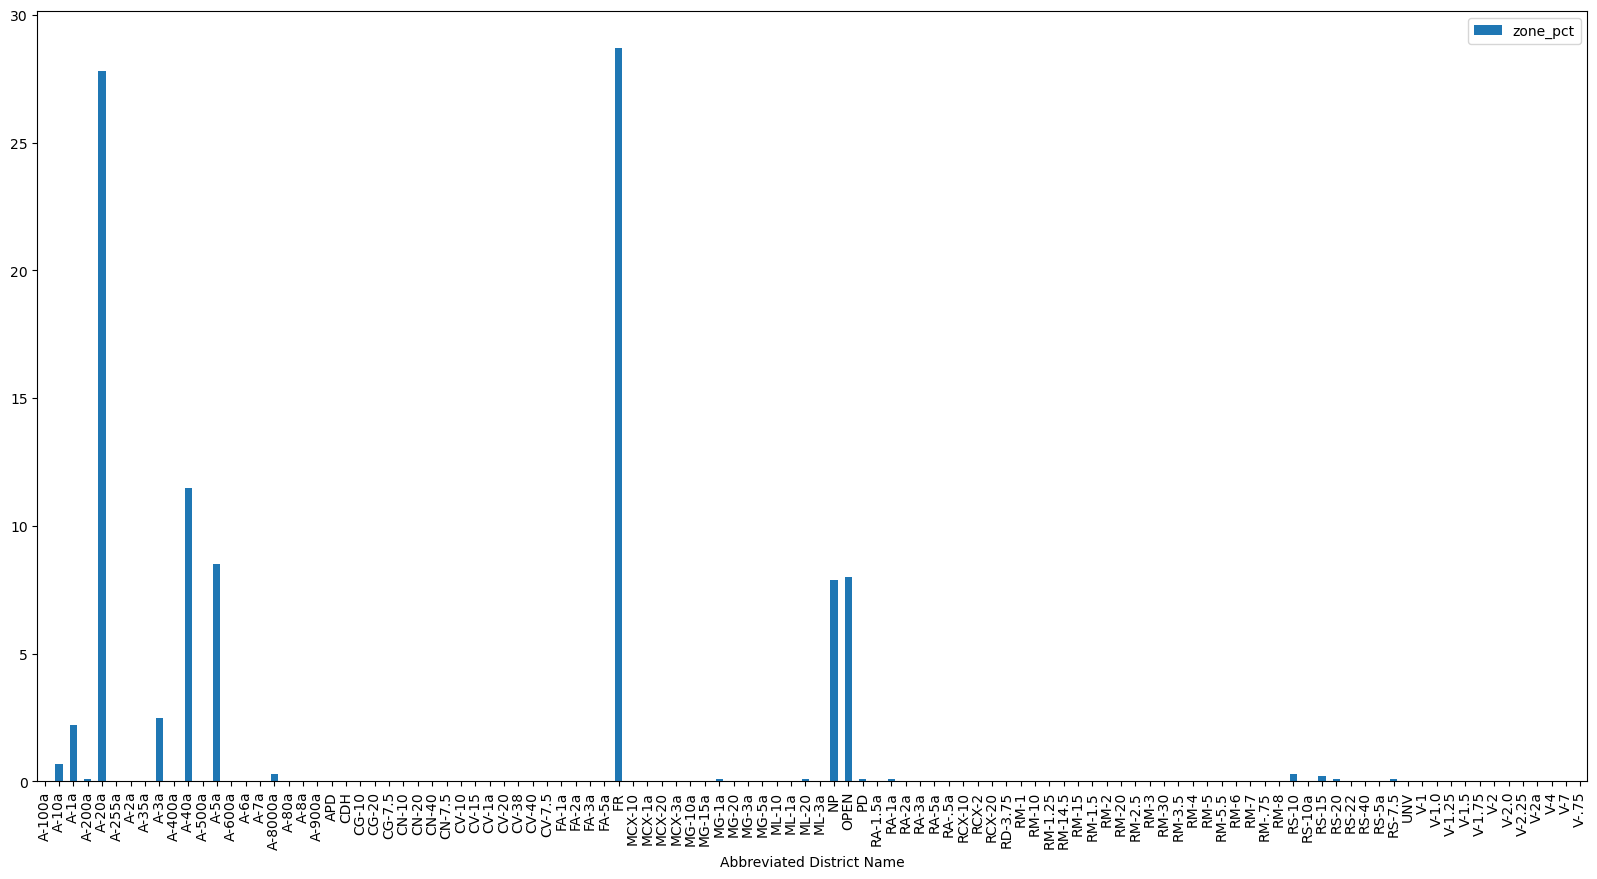

In [39]:
county.plot(kind = 'bar', 
           x = 'Abbreviated District Name', 
           y = 'zone_pct',
           figsize=(20, 10))

<AxesSubplot: xlabel='Abbreviated District Name'>

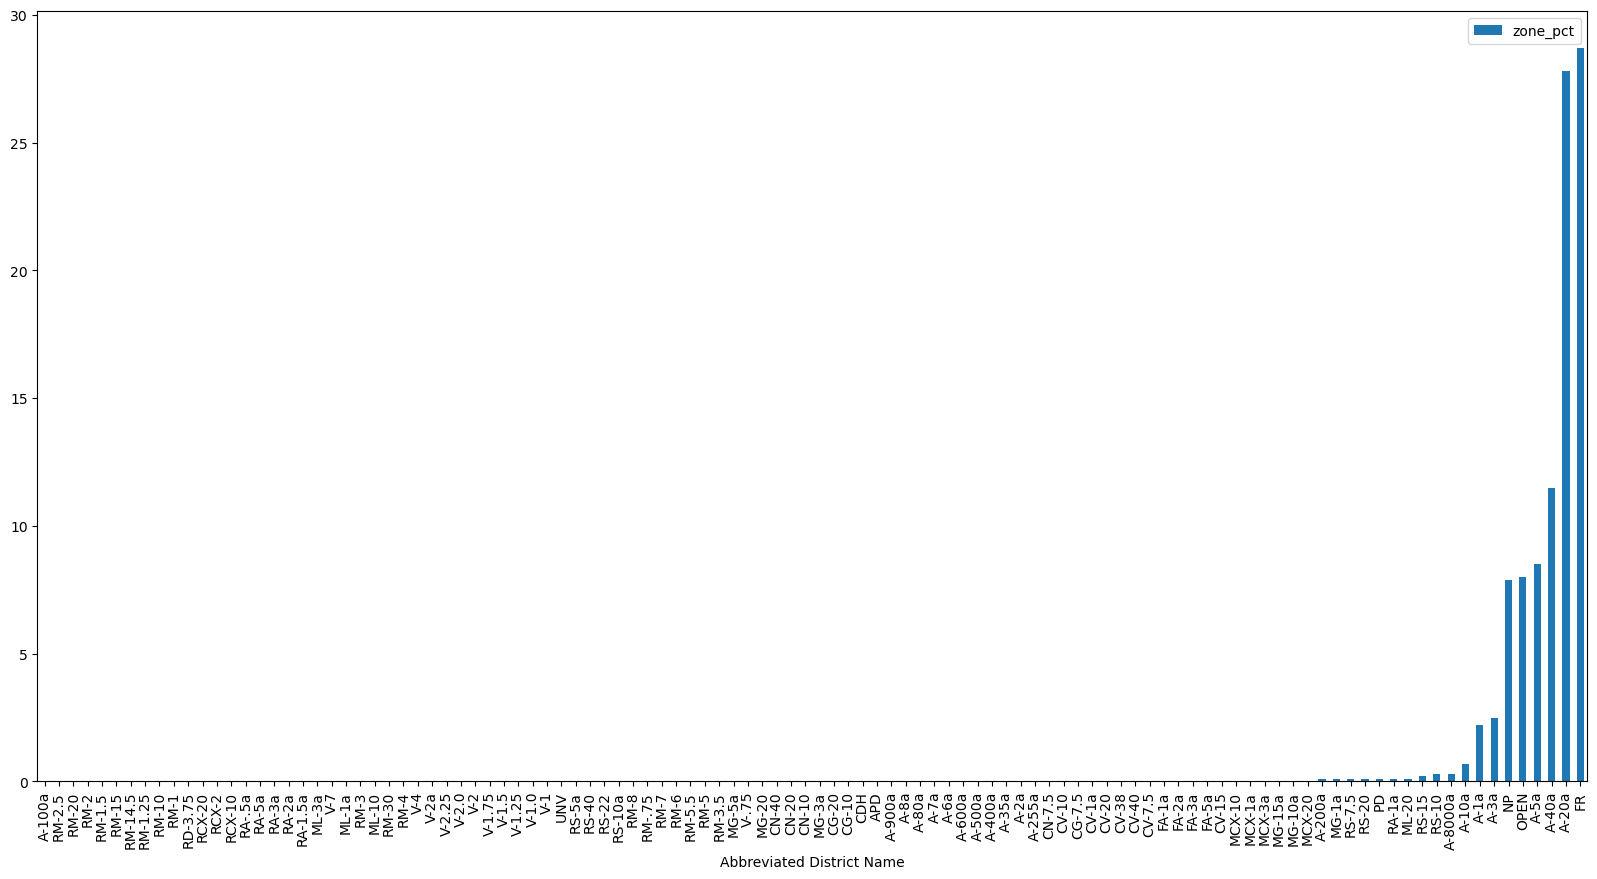

In [40]:
county = county.sort_values('zone_pct')

county.plot(kind = 'bar', 
           x = 'Abbreviated District Name', 
           y = 'zone_pct',
           figsize=(20, 10))

In [41]:
# export to file
county = county.drop('geometry', axis = 1)
county.to_csv('./output/by_county/county.csv')